In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
def generate_signal(sample_rate, frequency, amplitude, noise_level, phase_offset, duration=1.0):
    """
    Generate a sinusoidal signal with specified parameters. Can generate chirp signals with varying frequency.
    
    Parameters:
    -----------
    sample_rate : float
        Number of samples per second (Hz)
    frequency : float or tuple of (float, float)
        Frequency of the sine wave (Hz). Can be:
        - A single float for a stationary frequency signal
        - A tuple (start_freq, end_freq) for a chirp signal with linearly varying frequency
    amplitude : float
        Amplitude of the sine wave
    noise_level : float
        Standard deviation of Gaussian noise to add
    phase_offset : float
        Phase offset in radians
    duration : float, optional
        Duration of the signal in seconds (default: 1.0)
    
    Returns:
    --------
    t : numpy.ndarray
        Time array
    signal : numpy.ndarray
        Generated signal with noise
    """
    # Generate time array
    t = np.arange(0, duration, 1/sample_rate)
    
    # Parse frequency parameter
    if isinstance(frequency, (tuple, list)):
        start_frequency = frequency[0]
        end_frequency = frequency[1]
    else:
        start_frequency = frequency
        end_frequency = frequency
    
    # Generate clean signal
    if start_frequency == end_frequency:
        # Stationary frequency signal
        clean_signal = amplitude * np.sin(2 * np.pi * start_frequency * t + phase_offset)
    else:
        # Chirp signal with linearly varying frequency
        # Instantaneous frequency: f(t) = start_frequency + (end_frequency - start_frequency) * t / duration
        # Phase: integral of 2*pi*f(t) dt = 2*pi * (start_frequency*t + (end_frequency - start_frequency)*t^2 / (2*duration))
        instantaneous_phase = 2 * np.pi * (start_frequency * t + (end_frequency - start_frequency) * t**2 / (2 * duration))
        clean_signal = amplitude * np.sin(instantaneous_phase + phase_offset)
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, len(t))
    signal = clean_signal + noise
    
    return t, signal


In [107]:
duration_seconds = 60 * 20 
sample_rate = 100
t, sensor_signal_1a = generate_signal(sample_rate=sample_rate, frequency=[0.2, 0.7], amplitude=200, noise_level=5, phase_offset=0, duration=duration_seconds)
t, sensor_signal_1b = generate_signal(sample_rate=sample_rate, frequency=[1.1, 2.5], amplitude=10, noise_level=5, phase_offset=0.5, duration=duration_seconds)
sensor_signal_1 = sensor_signal_1a + sensor_signal_1b

# sensor_signal_1_df = pd.DataFrame({'time': t, 'signal': sensor_signal_1})

In [108]:
from numpy.lib.stride_tricks import sliding_window_view

batch_duration_seconds = 30
overlap_seconds = 1
batch_size = batch_duration_seconds * sample_rate
overlap = overlap_seconds * sample_rate

step = batch_size - overlap

batches = sliding_window_view(sensor_signal_1, batch_size)[::step]
print(len(batches))

41


In [109]:
x = np.empty((0, batch_size))
y = np.empty((0, batch_size))
for batch in batches:
    original_signal = batch
    
    # Alter the signal
    altered_signal = batch + np.random.normal(0, 30, len(batch))

    x = np.vstack([x, altered_signal])
    y = np.vstack([y, original_signal])

print(x.shape, y.shape)

(41, 3000) (41, 3000)


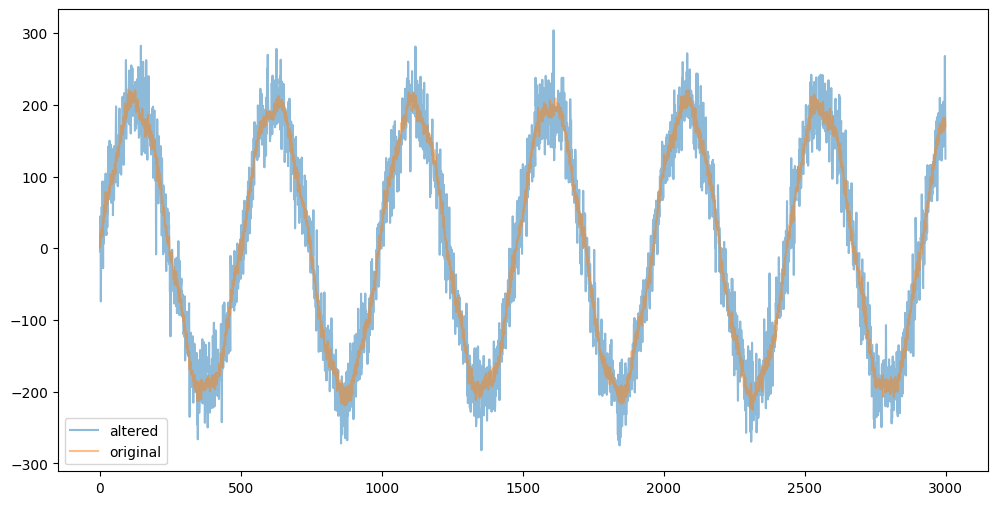

In [110]:
f = plt.figure(figsize=(12, 6))
plt.plot(x[0], label='altered', alpha=0.5)
plt.plot(y[0], label='original', alpha=0.5)
plt.legend()
plt.show()


In [111]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeStepDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()  # Convert to float32 for MPS compatibility
        self.Y = torch.from_numpy(Y).float()  # Convert to float32 for MPS compatibility

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_val_split = 0.8
x_train = x[:int(len(x) * train_val_split)]
y_train = y[:int(len(y) * train_val_split)]
x_val = x[int(len(x) * train_val_split):]
y_val = y[int(len(y) * train_val_split):]

train_ds = TimeStepDataset(x_train, y_train)
val_ds = TimeStepDataset(x_val, y_val)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=False)
val_loader  = DataLoader(val_ds,  batch_size=256, shuffle=False)

In [112]:
from lib.reconstruction_model import SignalReconstructor

model = SignalReconstructor()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: mps


SignalReconstructor(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReL

In [113]:
from torch import nn

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [114]:
import copy

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    total_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float()  # Convert to float32 for MPS compatibility
            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad()
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
                optimizer.step()

            total_loss += loss.item()
            total_batches += 1

    return total_loss / total_batches

best_val_loss = float('inf')
best_model_state = None
epochs_no_improve = 0
patience = 10
n_epochs = 1000
training_record = {}

for epoch in range(n_epochs):
    train_loss = run_epoch(train_loader, train=True)
    val_loss   = run_epoch(val_loader, train=False)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:02d}  train_loss={train_loss:.6f}  val_loss={val_loss:.6f}  lr={current_lr:.6f}")
    training_record[epoch] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'lr': current_lr
    }
    
    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  → New best model (val_loss={val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  → No improvement for {epochs_no_improve} epoch(s)")
    
    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

Epoch 01  train_loss=20136.605469  val_loss=20105.537109  lr=0.001000
  → New best model (val_loss=20105.5371)
Epoch 02  train_loss=20047.462891  val_loss=20098.431641  lr=0.001000
  → New best model (val_loss=20098.4316)
Epoch 03  train_loss=19974.812500  val_loss=20090.646484  lr=0.001000
  → New best model (val_loss=20090.6465)
Epoch 04  train_loss=19916.419922  val_loss=20081.662109  lr=0.001000
  → New best model (val_loss=20081.6621)
Epoch 05  train_loss=19867.001953  val_loss=20070.951172  lr=0.001000
  → New best model (val_loss=20070.9512)
Epoch 06  train_loss=19824.744141  val_loss=20058.365234  lr=0.001000
  → New best model (val_loss=20058.3652)
Epoch 07  train_loss=19789.583984  val_loss=20043.894531  lr=0.001000
  → New best model (val_loss=20043.8945)
Epoch 08  train_loss=19760.968750  val_loss=20026.964844  lr=0.001000
  → New best model (val_loss=20026.9648)
Epoch 09  train_loss=19737.257812  val_loss=20007.267578  lr=0.001000
  → New best model (val_loss=20007.2676)
E

In [115]:
# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss={best_val_loss:.4f}")


Restored best model with val_loss=4336.3838


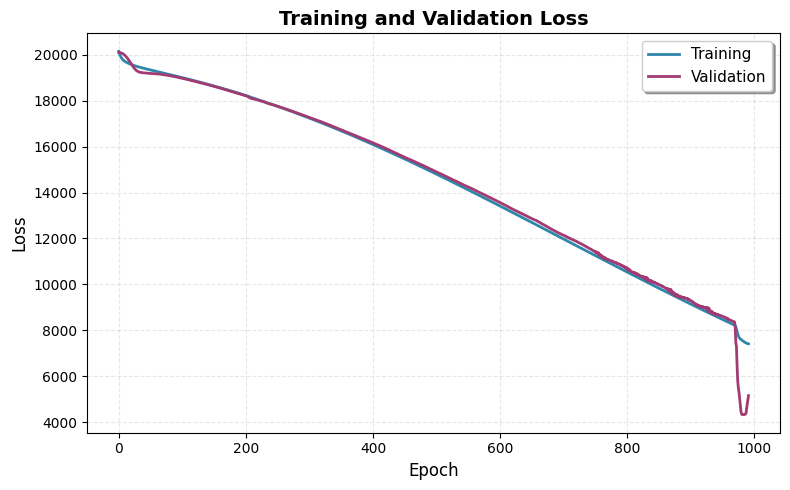

In [116]:
epochs_list = list(training_record.keys())
train_losses = [training_record[e]['train_loss'] for e in epochs_list]
val_losses = [training_record[e]['val_loss'] for e in epochs_list]

plt.figure(figsize=(8, 5))
plt.plot(epochs_list, train_losses, label='Training', linewidth=2, color='#2E86AB')
plt.plot(epochs_list, val_losses, label='Validation', linewidth=2, color='#A23B72')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('training_validation_loss.pdf', dpi=300, bbox_inches='tight')
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()


In [117]:
import datetime

model.eval()
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"reconstruction_model_{time_str}.pth"
torch.save({'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           model_path)

In [118]:
with torch.no_grad():
    x_t = torch.from_numpy(x.astype(np.float32)).to(device)
    preds = model(x_t).cpu().numpy()
    
results_df = pd.DataFrame({
    "true": list(y),
    "pred": list(preds)
}, index=np.arange(len(y)))

results_df["is_train"] = np.isin(results_df.index, x_train)
results_df["is_val"] = np.isin(results_df.index, x_val)

In [119]:
error = np.zeros(len(preds))
for i in range(len(preds)): 
    f = preds[i] - y[i]
    error[i] = f.sum()
    
results_df['error'] = error
results_df['error_abs'] = np.abs(results_df['error'])

results_df.head()

,true,pred,is_train,is_val,error,error_abs
0,"[1.4706305192414175, 11.306748959062329, 19.76...","[1.8178194, 2.1741467, 1.7232172, 4.313777, 3....",False,False,-27385.708564,27385.708564
1,"[-30.433159777429903, -39.600301168395646, -16...","[-0.5436982, -4.2731214, -3.721511, -10.227338...",False,False,-33796.335322,33796.335322
2,"[164.07336946376026, 196.46182977797733, 182.2...","[37.323425, 97.1108, 46.352913, 115.49674, 53....",False,False,-20617.307050,20617.307050
3,"[-18.236424731924036, -5.743173653689727, -19....","[0.4427749, -0.68221796, 0.18733203, 0.5111502...",False,False,-28381.845544,28381.845544
4,"[4.6350197388180785, 16.546328088906122, 11.46...","[1.6592937, 1.6960928, 1.4865139, 3.5487099, 2...",False,False,-32247.922956,32247.922956


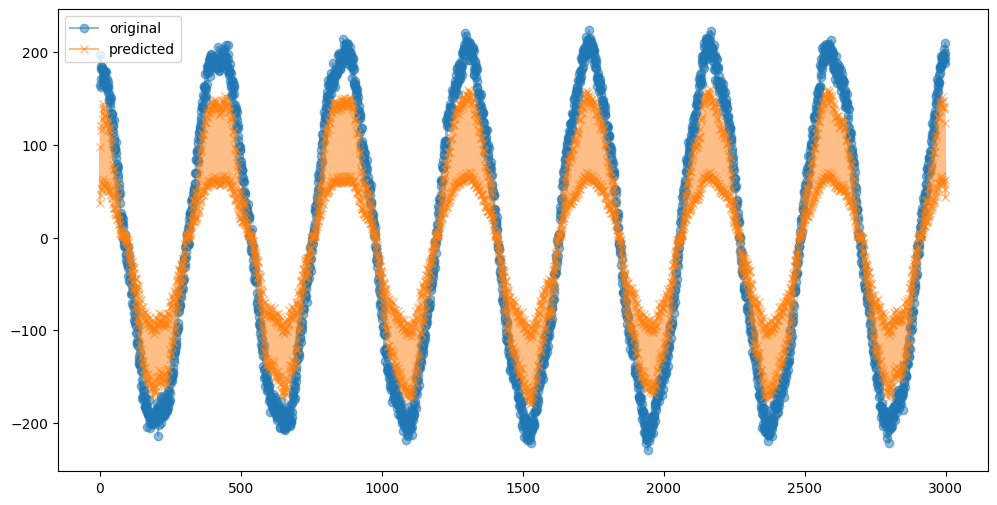

In [124]:
f = plt.figure(figsize=(12, 6))

i = np.random.randint(0, len(results_df))
plt.plot(results_df.true.iloc[i], label='original', alpha=0.5, marker='o')
plt.plot(results_df.pred.iloc[i], label='predicted', alpha=0.5, marker='x')
plt.legend()
plt.show()


Generate a bunch of these train a model with a contrastive loss using slightly different altered versions of the signal. Post train on top of those embeddings to estimate the frequency of the low and high amplitude signals.